In [89]:
# import module

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
from astrodendro import analysis
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as const

In [90]:
cgs_mp = 9.10938291e-28
cgs_me = 9.10938291e-28 
cgs_xmh =  cgs_mp + cgs_me
yHe = 9.7222222e-2 
mu = (1.e0+4.e0*yHe)*cgs_xmh
pc = 3.0856775814671916*10**18 #cm
solar_mass = 1.989*10**33 #g

In [91]:
def get_data(filename):
  d = {}
  with h5py.File(filename, "r") as data:
    data_list = list(data)
    for ls in data_list:
      d[ls] = data[ls][()]
  return d

In [92]:
d = get_data('C:/Users/kotor/StarGen/datasets/data_ppp/cb2200.h5')

hx = d['space1']
hy = d['space2']
hz = d['space3']

nH = d['nH']
rho = nH * mu
m = rho * (hx*pc)**3 / solar_mass

<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_4532\2701856401.py:14: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')


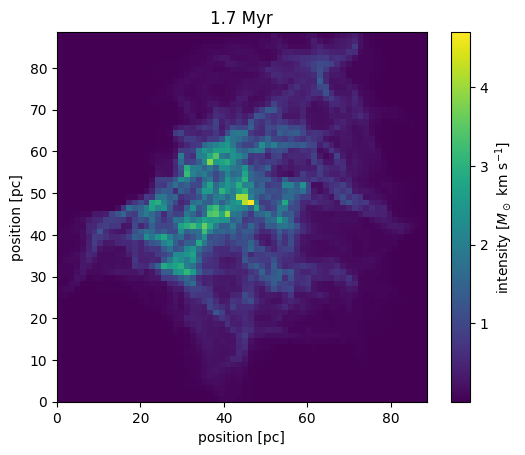

In [93]:
# make int map

int_map = np.sum(m, axis=0) * hx
extent = [0, hy * m.shape[1], 0, hz * m.shape[2]]

fig, ax = plt.subplots()
im = ax.imshow(int_map, extent=extent, origin='lower')

ax.set_title("1.7 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')

cbar = fig.colorbar(im)
cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')

In [94]:
# compute dendrogram

min_value = 0.9
min_delta = 0.3
min_npix = 20

dendro = Dendrogram.compute(int_map, min_value=min_value, min_delta=min_delta, min_npix=min_npix)

In [104]:
# make feature list

leaf_indices = [i for i, structure in enumerate(dendro) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro) if structure.is_branch]

leaf_npix, branch_npix = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix() 
    leaf_npix.append(npix)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    npix = structure.get_npix()
    branch_npix.append(npix)    
leaf_sizes = np.array(leaf_npix) * hy * hz
branch_sizes = np.array(branch_npix) * hy * hz

mass_per_leaf, mass_per_branch = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    leaf_mass = np.sum(int_map[indices])
    mass_per_leaf.append(leaf_mass)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    branch_mass = np.sum(int_map[indices])
    mass_per_branch.append(branch_mass)
mass_per_leaf = np.array(mass_per_leaf) / hx
mass_per_branch = np.array(mass_per_branch) / hx

x_peak, y_peak, peak_value = [], [], []
for s in dendro.leaves:
    y_ch, x_ch = s.get_peak()[0]
    value = s.get_peak()[1]
    x_peak.append(round(float(x_ch), 6) * hx)
    y_peak.append(round(float(y_ch), 6) * hy)
    peak_value.append(round(float(value), 6))

leaf_radius = np.sqrt(np.array(leaf_sizes) / np.pi)
branch_radius = np.sqrt(np.array(branch_sizes) / np.pi)

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)
def fit_gaussian(x, *params):
    num_peaks = len(params) // 3
    result = np.zeros_like(x, dtype='float')
    for i in range(num_peaks):
        result += gaussian(x, params[i * 3], params[i * 3 + 1], params[i * 3 + 2])
    return result
def calculate_fwhm(stddev):
    return 2 * np.sqrt(2 * np.log(2)) * stddev
fwhm_leaf, fwhm_branch = [], []
for structure_index in leaf_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    spectra_list = []
    for i, j in coordinates_list:
        spectra_list.append(m[:, i, j])
    spe = np.sum(spectra_list, axis=0)
    x_spe = np.arange(len(spe))
    num_peaks = 1
    initial_params = [1, np.argmax(spe), 1] * num_peaks
    params, covariance = curve_fit(fit_gaussian, x_spe, spe, p0=initial_params)
    fit_curve = fit_gaussian(x_spe, *params)
    for i in range(num_peaks):
        fwhm_leaf.append(calculate_fwhm(params[i * 3 + 2])*0.65)
for structure_index in branch_indices:
    structure = dendro[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    spectra_list = []
    for i, j in coordinates_list:
        spectra_list.append(m[:, i, j])
    spe = np.sum(spectra_list, axis=0)
    x_spe = np.arange(len(spe))
    num_peaks = 1
    initial_params = [1, np.argmax(spe), 1] * num_peaks
    params, covariance = curve_fit(fit_gaussian, x_spe, spe, p0=initial_params)
    fit_curve = fit_gaussian(x_spe, *params)
    for i in range(num_peaks):
        fwhm_branch.append(calculate_fwhm(params[i * 3 + 2])*0.65)

vir_leaf = 1.2 * 10**3 * np.array(leaf_radius) * np.array(fwhm_leaf)**2 / (3 * np.array(mass_per_leaf))
vir_branch = 1.2 * 10**3 * np.array(branch_radius) * np.array(fwhm_branch)**2 / (3 * np.array(mass_per_branch))

leaf_feature = pd.DataFrame({
    'id':leaf_indices, 
    'leaf_size [pc^2]':leaf_sizes, 
    'leaf_mass [solar mass]':mass_per_leaf,
    'x_peak':x_peak, 
    'y_peak':y_peak, 
    'peak_value [solar mass]':peak_value,
    'leaf_radius [pc]':leaf_radius,
    'fwhm [km/s]':'',
    'virial_parameter':''})
branch_feature = pd.DataFrame({
    'id':branch_indices, 
    'branch_size [pc^2]':branch_sizes, 
    'branch_mass [solar mass]':mass_per_branch,
    'branch_radius [pc]':branch_radius,
    'fwhm [km/s]':'',
    'virial_parameter':''})

leaf_size_ave = np.sum(leaf_sizes) / len(leaf_indices)
branch_size_ave = np.sum(branch_sizes) / len(branch_indices)
leaf_mass_ave = np.sum(mass_per_leaf) / len(leaf_indices)
branch_mass_ave = np.sum(mass_per_branch) / len(branch_indices)
leaf_vir_ave = np.sum(vir_leaf) / len(leaf_indices)
branch_vir_ave = np.sum(vir_branch) / len(branch_indices)

display(leaf_feature)
print('leaf size average:', leaf_size_ave)
print('leaf mass average:', leaf_mass_ave)
#print('leaf virial parameter average:', leaf_vir_ave)
display(branch_feature)
print('branch size average:', branch_size_ave)
print('branch mass average:', branch_mass_ave)
#print('branch virial parameter average:', branch_vir_ave)


,id,leaf_size [pc^2],leaf_mass [solar mass],x_peak,y_peak,peak_value [solar mass],leaf_radius [pc],fwhm [km/s],virial_parameter
0,1,42.156923,19.259471,52.602539,30.454102,1.508705,3.663191,,
1,3,40.240699,36.774012,30.454102,30.454102,3.091501,3.578968,,
2,5,86.230069,92.688766,45.681152,47.065430,4.700244,5.239073,,
3,6,40.240699,39.145864,35.991211,56.755371,3.890828,3.578968,,


leaf size average: 52.21709758043289
leaf mass average: 46.9670282452675


,id,branch_size [pc^2],branch_mass [solar mass],branch_radius [pc],fwhm [km/s],virial_parameter
0,0,937.033421,593.174759,17.270408,,
1,2,869.965589,565.297372,16.640873,,
2,4,222.281957,203.970062,8.411572,,


branch size average: 676.4269888401031
branch mass average: 454.1473978599009


Text(0, 0.5, 'position [pc]')

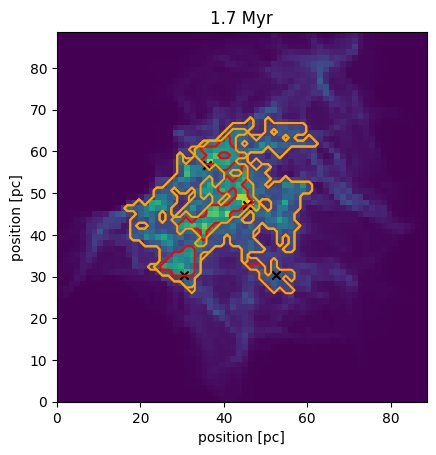

In [96]:
# plot the contour and peak

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(int_map, extent=extent, origin='lower')

p = dendro.plotter()

for index_leaf in leaf_indices:
    p.plot_contour(ax, extent=extent, structure=index_leaf, colors='red')
for index_branch in branch_indices:
    p.plot_contour(ax, extent=extent, structure=index_branch, colors='orange')

ax.scatter(leaf_feature['x_peak'], leaf_feature['y_peak'], marker='x', color='black')

ax.set_title("1.7 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')